# Create trading Algorithm using Bitcoin daily data from yfinance from 9-10-2014 - 9-10-2023


In [1]:
# Superivised Machine Learning Modules
    # Logistic Regression
    # Linear Regression
    # K-nearest neighbors
    # Decision Trees
    # Random Forests
    # SVM
    # Neural Networks
    
    

In [2]:
# Create machine learning trading algo to optimise for returns
# Each team member use different ML module and try and create a trading strategy using Bitcoin daily data from dates above to generate a profitable strategy. 

### Frame The Problem
The task is to create a Bitcoin machine learning trading algorithmn that optimises returns so a regression function and supervised learning will be used.       
How do we expect to use and benefit from this model?  
What performance measure to use?  
What are the assumptions?  
How to solve the problem manually?


### Performance Measures to Use   
#### To evaluate the quality of the predictive model:

**Mean Squared Error (MSE)** is a measure of the average squared difference between predicted values (y_pred) and actual values (y_test). It quantifies the overall accuracy of a regression model. Lower MSE values indicate better model performance, while higher values indicate worse performance.

**R-squared (R2)** is a statistical measure that represents the proportion of the variance in the dependent variable (y_test) that is predictable from the independent variable (y_pred). R2 values range from 0 to 1. A higher R2 indicates that the model explains a larger portion of the variance in the target variable.

#### To evaluate strategy's profitability:

**Total Return** calculates the total return of trading strategy as a percentage. It measures how much the portfolio has grown or shrunk over the entire trading period. The formula used calculates the percentage return based on the cumulative returns of the trading strategy. The cumulative returns column is typically used to track the performance of the strategy over time.

**Annualized Return** expresses the total return over a given period as an annual rate of return. It provides a way to compare the strategy's performance with other investments or strategies that may have different timeframes.
The formula used annualizes the total return, taking into account the length of the trading period (given by len(y_test))

#### To assess the risk-return trade-off:
**Sharpe Ratio** is a measure of the risk-adjusted return of an investment or strategy. It helps assess whether the excess return (return above a risk-free rate) justifies the additional risk taken.
The formula used here calculates the Sharpe ratio based on the mean (average) of the predicted returns and their standard deviation, adjusting for the number of trading days in a year (365). A higher Sharpe ratio typically indicates better risk-adjusted performance. 


### Get the Data and Import Libraries


In [3]:
#imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Import the BTC-AUD dataset into a Pandas Dataframe
btc_df = pd.read_csv(
    Path("./BTC-AUD.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

In [5]:
# Review the DataFrame
btc_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-09,399.171661,435.658539,391.848328,416.601227,416.601227,95458918
2014-10-10,416.214355,427.426758,405.331879,416.306274,416.306274,50277145
2014-10-11,416.075989,422.787567,409.845703,417.154877,417.154877,15365803
2014-10-12,417.508331,437.739990,410.067963,436.267151,436.267151,20229111
2014-10-13,435.543365,453.506134,422.562439,446.136444,446.136444,40248429
...,...,...,...,...,...,...
2023-10-05,43478.867188,43997.480469,43171.464844,43926.378906,43926.378906,17607838598
2023-10-06,43925.199219,44230.550781,43056.265625,43045.859375,43045.859375,18648535373
2023-10-07,43039.910156,44255.226563,43024.632813,43775.996094,43775.996094,21134698079


### Get Insights of the Data

In [6]:
btc_df.hvplot.line(x="Date", y="Close")

:Curve   [Date]   (Close)

In [7]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2014-10-09 to 2023-10-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3288 non-null   float64
 1   High       3288 non-null   float64
 2   Low        3288 non-null   float64
 3   Close      3288 non-null   float64
 4   Adj Close  3288 non-null   float64
 5   Volume     3288 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 179.8 KB


In [8]:
btc_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3.288000e+03
mean,19641.320293,20085.172584,19158.403958,19652.053609,19652.053609,2.331877e+10
std,21812.565291,22313.856971,21245.802999,21809.290611,21809.290611,2.657865e+10
min,217.344894,257.455017,210.286896,218.826630,218.826630,6.757192e+06
25%,1218.808930,1224.354431,1190.458374,1218.746216,1218.746216,2.068370e+08
50%,11345.301269,11656.556640,11006.660157,11353.556640,11353.556640,1.587150e+10
75%,32244.785156,32841.286133,31647.302735,32246.588379,32246.588379,3.849653e+10
max,91103.179688,93136.890625,90001.531250,91126.234375,91126.234375,4.554690e+11


In [9]:
# Calculate RSI
def calculate_rsi(data, period):
    price_diff = data['Close'].diff()
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    relative_strength = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + relative_strength))
    
    return rsi

In [10]:
# Add RSI to the DataFrame
btc_df['RSI'] = calculate_rsi(btc_df, period=14)

In [11]:
# Define trade signal logic (where RSI > 70 is a sell signal and RSI < 30 is a buy signal)
btc_df['Signal'] = 0  # Initialize the 'Signal' column

In [12]:
# Set trade signals based on RSI scale threshold values
overbought_threshold = 70 # suggests that the asset's price has increased significantly over the chosen period, and it may be due for a potential reversal or correction.
oversold_threshold = 30 # suggests that the asset's price has decreased significantly over the chosen period, and it may be due for a potential reversal or rebound.

btc_df.loc[btc_df['RSI'] > overbought_threshold, 'Signal'] = -1  # Sell signal
btc_df.loc[btc_df['RSI'] < oversold_threshold, 'Signal'] = 1   # Buy signal

In [30]:
btc_df

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,Predicted Returns,Cumulative Returns
Date,,,,,,,,,,
2014-10-09,399.171661,435.658539,391.848328,416.601227,416.601227,95458918,NaN,0,0.000000,1.000000
2014-10-10,416.214355,427.426758,405.331879,416.306274,416.306274,50277145,NaN,0,0.000000,1.000000
2014-10-11,416.075989,422.787567,409.845703,417.154877,417.154877,15365803,NaN,0,0.000000,1.000000
2014-10-12,417.508331,437.739990,410.067963,436.267151,436.267151,20229111,NaN,0,0.000000,1.000000
2014-10-13,435.543365,453.506134,422.562439,446.136444,446.136444,40248429,NaN,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
2023-10-05,43478.867188,43997.480469,43171.464844,43926.378906,43926.378906,17607838598,66.701126,0,-0.001318,3.871329
2023-10-06,43925.199219,44230.550781,43056.265625,43045.859375,43045.859375,18648535373,64.561913,0,0.002429,3.880731
2023-10-07,43039.910156,44255.226563,43024.632813,43775.996094,43775.996094,21134698079,70.929287,-1,-0.003398,3.867543


In [36]:
btc_df_copy = btc_df.dropna().copy()
btc_df_copy

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,Predicted Returns,Cumulative Returns
Date,,,,,,,,,,
2014-10-22,440.522552,442.569458,435.016479,437.095581,437.095581,13280059,60.248656,0,0.000000,1.000000
2014-10-23,436.872009,439.904053,406.995880,409.525818,409.525818,30229548,47.226533,0,0.000000,1.000000
2014-10-24,409.724640,413.323883,402.994171,407.488068,407.488068,17723107,46.589971,0,0.000000,1.000000
2014-10-25,407.790527,409.211945,389.898804,394.895386,394.895386,20613486,42.108925,0,0.000000,1.000000
2014-10-26,395.140991,408.484192,391.097351,402.935364,402.935364,12805294,37.177114,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
2023-10-05,43478.867188,43997.480469,43171.464844,43926.378906,43926.378906,17607838598,66.701126,0,-0.001318,3.871329
2023-10-06,43925.199219,44230.550781,43056.265625,43045.859375,43045.859375,18648535373,64.561913,0,0.002429,3.880731
2023-10-07,43039.910156,44255.226563,43024.632813,43775.996094,43775.996094,21134698079,70.929287,-1,-0.003398,3.867543


In [39]:
# Use the RSI signal as the feature (X) and price change as the target variable (y)
X = btc_df_copy[['RSI']].values
y = btc_df_copy['Close'].pct_change().dropna().values

In [40]:
# Ensure that X and y have the same number of samples
X = X[:-1]  # Remove the last row of X to match the lengths of X and y to solve the imbalance error from the initial run

In [41]:
# Split the data into training and testing sets...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Initialize the linear regression model
model = LinearRegression()

In [43]:
# Fit the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [44]:
# Make predictions on the test data
y_pred = model.predict(X_test)

In [46]:
# Implement a basic trading strategy based on the model predictions
btc_df_copy['Predicted Returns'] = 0  # Initialize a column for predicted returns
btc_df_copy['Predicted Returns'].iloc[-len(y_test):] = y_pred  # Fill in predicted returns

/var/folders/_9/k8qj85q9101b4nrg3qh4f1wr0000gn/T/ipykernel_1247/3800715119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df_copy['Predicted Returns'].iloc[-len(y_test):] = y_pred  # Fill in predicted returns


In [47]:
# Calculate portfolio returns and other performance metrics

# Calculate the cumulative portfolio returns over time...
btc_df_copy['Cumulative Returns'] = (1 + btc_df_copy['Predicted Returns']).cumprod()

In [48]:
btc_df_copy

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,Predicted Returns,Cumulative Returns
Date,,,,,,,,,,
2014-10-22,440.522552,442.569458,435.016479,437.095581,437.095581,13280059,60.248656,0,0.000000,1.000000
2014-10-23,436.872009,439.904053,406.995880,409.525818,409.525818,30229548,47.226533,0,0.000000,1.000000
2014-10-24,409.724640,413.323883,402.994171,407.488068,407.488068,17723107,46.589971,0,0.000000,1.000000
2014-10-25,407.790527,409.211945,389.898804,394.895386,394.895386,20613486,42.108925,0,0.000000,1.000000
2014-10-26,395.140991,408.484192,391.097351,402.935364,402.935364,12805294,37.177114,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
2023-10-05,43478.867188,43997.480469,43171.464844,43926.378906,43926.378906,17607838598,66.701126,0,0.004680,3.774472
2023-10-06,43925.199219,44230.550781,43056.265625,43045.859375,43045.859375,18648535373,64.561913,0,0.000238,3.775370
2023-10-07,43039.910156,44255.226563,43024.632813,43775.996094,43775.996094,21134698079,70.929287,-1,0.000829,3.778501


In [51]:
btc_df_copy['Rebased Close'] = btc_df_copy['Close'] / btc_df_copy['Close'][0]
btc_df_copy

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,Predicted Returns,Cumulative Returns,Rebased Close
Date,,,,,,,,,,,
2014-10-22,440.522552,442.569458,435.016479,437.095581,437.095581,13280059,60.248656,0,0.000000,1.000000,1.000000
2014-10-23,436.872009,439.904053,406.995880,409.525818,409.525818,30229548,47.226533,0,0.000000,1.000000,0.936925
2014-10-24,409.724640,413.323883,402.994171,407.488068,407.488068,17723107,46.589971,0,0.000000,1.000000,0.932263
2014-10-25,407.790527,409.211945,389.898804,394.895386,394.895386,20613486,42.108925,0,0.000000,1.000000,0.903453
2014-10-26,395.140991,408.484192,391.097351,402.935364,402.935364,12805294,37.177114,0,0.000000,1.000000,0.921847
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-05,43478.867188,43997.480469,43171.464844,43926.378906,43926.378906,17607838598,66.701126,0,0.004680,3.774472,100.496049
2023-10-06,43925.199219,44230.550781,43056.265625,43045.859375,43045.859375,18648535373,64.561913,0,0.000238,3.775370,98.481571
2023-10-07,43039.910156,44255.226563,43024.632813,43775.996094,43775.996094,21134698079,70.929287,-1,0.000829,3.778501,100.151999


### Calculate Performance Metrics

In [52]:

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
total_return = (btc_df_copy['Cumulative Returns'].iloc[-1] - 1) * 100  # Total return as a percentage
annualized_return = ((1 + total_return / 100) ** (365 / len(y_test)) - 1) * 100  # Annualized return
sharpe_ratio = (btc_df_copy['Predicted Returns'].mean() / btc_df_copy['Predicted Returns'].std()) * np.sqrt(365)  # Sharpe ratio

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Mean Squared Error (MSE): 0.0012
R-squared (R2): 0.0040
Total Return: 279.97%
Annualized Return: 110.41%
Sharpe Ratio: 7.2855


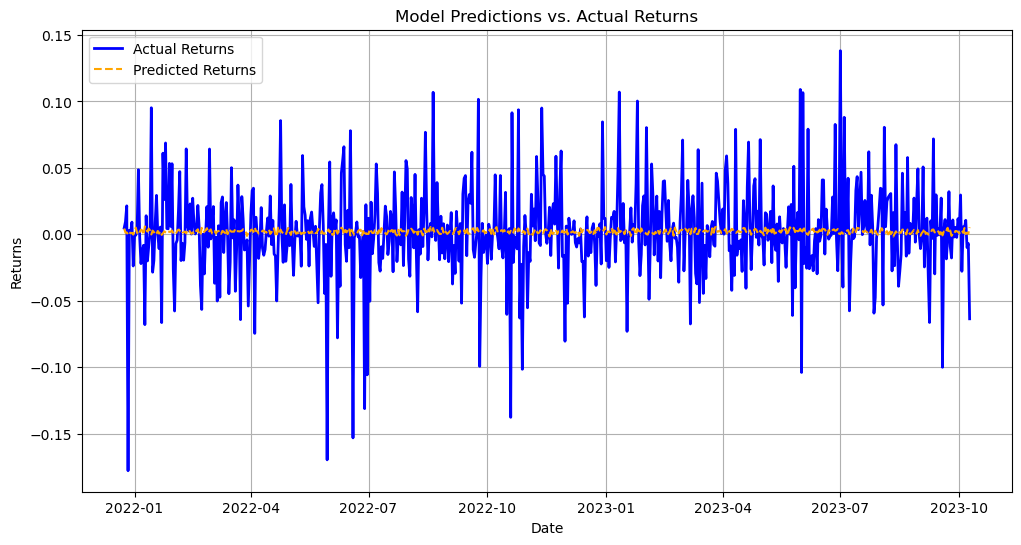

In [53]:
# Create a time series plot to visualize predictions and actual returns
plt.figure(figsize=(12, 6))

# Plot the actual returns in blue
plt.plot(btc_df_copy.index[-len(y_test):], y_test, label='Actual Returns', color='blue', linewidth=2)

# Plot the model's predictions in orange
plt.plot(btc_df_copy.index[-len(y_test):], y_pred, label='Predicted Returns', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Model Predictions vs. Actual Returns')
plt.legend()
plt.grid(True)

plt.show()